In [1]:
import json
import pandas as pd

C:\Users\lpesk\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
def get_prolific_pid(x):
    d = json.loads(x)
    if "PROLIFIC_PID" not in d:
        return ""
    return d["PROLIFIC_PID"]


In [3]:
# df_interaction = pd.read_json("./data/18-4-2023 19-18/interaction-export.json", encoding='utf-8')
# df_interaction = df_interaction[df_interaction.interaction_type == "final-questionnaire"]
# df_participation = pd.read_json("data/18-4-2023 19-18/participation-export.json", encoding="utf-8")
# df_participation.loc[:, "prolific_pid"] = df_participation.extra_data.map(get_prolific_pid)
# df_participation = df_participation[df_participation.user_study_id >= 4]
# df_participation = df_participation.set_index("id")
# df_participation = df_participation[df_participation.participant_email != "a@a.a"]
# df_interaction = df_interaction[df_interaction.participation.isin(df_participation.index)]

In [4]:
df_interaction = pd.read_json("data/raw_final/interaction-export.json", encoding='utf-8')
df_interaction_raw = df_interaction.copy()
#df_interaction = df_interaction.apply(set_iteration, axis=1)
#df_interaction['iteration'] = df_interaction.groupby(['participation'], sort=False, group_keys=False)['iteration'].apply(lambda x: x.ffill())
df_interaction = df_interaction.dropna()
#df_interaction.iteration = df_interaction.iteration.astype(int)
df_participation = pd.read_json("data/raw_final/participation-export.json", encoding='utf-8')
df_participation.loc[:, "prolific_pid"] = df_participation.extra_data.map(get_prolific_pid)
df_participation = df_participation[df_participation.time_finished.notna()]
df_participation = df_participation[df_participation.participant_email != "a@a.a"]
df_participation = df_participation[df_participation.time_finished.notna()]
df_participation = df_participation[df_participation.user_study_id >= 4]

df_interaction = df_interaction[df_interaction.participation.isin(df_participation.id)]
df_interaction = df_interaction[df_interaction.interaction_type == "final-questionnaire"]

In [5]:
final_questionnaire = df_interaction[df_interaction.interaction_type == 'final-questionnaire']
print(final_questionnaire.shape)
def set_failed(row):
    d = json.loads(row.data)
    hits = 0
    hits += int(d['qs1']) == 1
    hits += int(d['qs2']) == -2
    hits += int(d['qs3']) <= 1
    row['failed'] = hits <= 1
    row['hits'] = hits
    return row
final_questionnaire = final_questionnaire.apply(set_failed, axis=1)
final_questionnaire = final_questionnaire.loc[final_questionnaire.failed == False]
print(final_questionnaire.shape)

(108, 5)
(106, 7)


In [6]:
df_participation = df_participation.set_index("id") 
df_participation.head()

participant_email  age_group  gender  education  \
id                                                                             
60                                                     21       2          2   
61                 patrykwitkowski13@gmail.com         21       0          4   
62  5fbea04315b8cb0597ec2109@email.prolific.co         21       1          4   
63                    filip.jarosinski@onet.pl         16       0          2   
64  6140a2afeec61853de540a8b@email.prolific.co         16       0          2   

    ml_familiar  user_study_id                 time_joined  \
id                                                           
60         True              4  2023-04-13 20:38:34.895767   
61         True              4  2023-04-13 20:39:02.879787   
62        False              4  2023-04-13 20:43:10.052388   
63         True              4  2023-04-13 20:43:16.100141   
64        False              4  2023-04-13 20:52:01.521540   

                 time_finished                    uuid language  \
id                                                                
60  2023-04-13 21:12:16.325727  s8wS3j4FpVjVqnfLHRDrOg       en   
61  2023-04-13 20:48:30.231083  Qb8DiFnPdrsJjq23q9Bhig       en   
62  2023-04-13 21:21:37.978370  5ljzdjgzyXhTMfm1YXtfIA       en   
63  2023-04-13 21:02:20.445787  3vfcoictviZpzj3x-oDM8Q       en   
64  2023-04-13 21:05:57.780778  Nn2jbFfvKIE3LhfWWgkYwA       en   

                                           extra_data  \
id                                                      
60  {"PROLIFIC_PID": "5b58d79b71a4100001555c56", "...   
61  {"PROLIFIC_PID": "603e509ec71a1ce243aba9d2", "...   
62  {"PROLIFIC_PID": "5fbea04315b8cb0597ec2109", "...   
63  {"PROLIFIC_PID": "60802340137e137ee1b9529c", "...   
64  {"PROLIFIC_PID": "6140a2afeec61853de540a8b", "...   

                prolific_pid  
id                            
60  5b58d79b71a4100001555c56  
61  603e509ec71a1ce243aba9d2  
62  5fbea04315b8cb0597ec2109  
63  60802340137e137ee1b9529c  
64  6140a2afeec61853de540a8b

In [7]:
for _, row in df_interaction.iterrows():
    d = json.loads(row["data"])
    participant = df_participation.loc[row.participation]
    pid = participant.prolific_pid
    if "qs1" not in d:
        print(f"Weird: {pid}, {participant.participant_email}")
    else:
        correct = 0
        if d["qs1"] == "1":
            correct += 1
        if d["qs2"] == "-2":
            correct += 1
        if d["qs3"] == "-2" or d["qs3"] == "-1":
            correct += 1
        
        if correct <= 1:
            print(f"User {pid} ({participant.participant_email}) has just {correct}/3 correct answers!")

User 5be84b9a40b06b0001370c9f () has just 1/3 correct answers!
User 60e96a37211cf04eb272efa2 (nthatimanchidi9@gmail.com) has just 1/3 correct answers!


In [8]:
q_to_text = {
    "q1": "The movies recommended to me matched my interests.",
    "q2": "The recommended movies were novel to me.",
    "q3": "The recommended movies were diverse.",
    "q4": "The information provided for the recommended movies was sufficient to judge whether I gonna like them.",
    "0ch": "Do you remember the following movie?",
    "q6": "I found it easy to tell the system what movies I like or dislike.",
    "q7": "I found it easy to tell the system whether it did a good job.",
    "q8": "The description of relevance, diversity, and, novelty was clear and sufficient.",
    "q9": "I understood the purpose of tweaking relevance, diversity, and novelty.",
    "qs1": "I believe recommender systems can be very useful to people. To answer this attention check question correctly, you must select 'Agree'",
    "q11": "The initial values of sliders already provided good recommendations.",
    "q12": "Being able to change relevance, diversity, and novelty ratios was useful for me.",
    "q13": "Overall, the effect of tweaking relevance, diversity, and novelty fulfilled my expectations.",
    "1ch": "Do you remember the following movie?",
    "q15": "Overall, after modifying the relevance, diversity, and novelty ratios, recommendations improved.",
    "q16": "Modifying relevance, diversity, and, novelty values had a visible effect on the upcoming recommendations.",
    "q17": "The mechanism (slider) provided me with sufficient control over the recommendations.",
    "q18": "The mechanism (slider) was sufficient to tell the system what recommendations I want.",
    "qs2": "Using this recommender system was entertaining and I would recommend it to my friends. To answer this attention check question correctly, you must select 'Strongly Disagree'.",
    "q20": "I was not able to describe my preferences w.r.t. relevance, diversity, and novelty.",
    "q21": "The mechanism (slider) for tweaking the objectives was understandable and intuitive.",
    "2ch": "Do you remember the following movie?",
    "q23": "Appropriate values of relevance, diversity, and novelty ratios were easy to set.",
    "q24": "Overall, I am satisfied with the recommender.",
    "qs3": "This recommender system provided me with many tips for interesting computer games."
}

a_to_text = {
    "-2": "Strongly Disagree",
    "-1": "Disagree",
    "0": "Neutral",
    "1": "Agree",
    "2": "Strongly Agree",
    "3": "I don't understand",
    "ch0": "Was not recommended at all",
    "ch1": "Was among recommendations",
    "ch2": "I selected the movie",
    "ch3": "I am not sure"
}

In [9]:
def columnify_answers(row):
    d = json.loads(row.data)
    ch_counter = 0
    for key, value in d.items():
        if key.startswith("q"):
            row[key] = value
        elif key.endswith("ch"):
            idx = key.split("ch")[0]
            for attn in d["attention_check"]:
                if attn["movie_idx"] == idx:
                    if not attn["gold"]["recommended"]:
                        gold = 0
                    elif attn["gold"]["recommended"] and not attn["gold"]["selected"]:
                        gold = 1
                    elif attn["gold"]["recommended"] and attn["gold"]["selected"]:
                        gold = 2
            row[f"{ch_counter}ch"] = value
            row[f"{ch_counter}ch_true"] = gold
            ch_counter += 1
    return row

In [10]:
df_interaction = df_interaction.apply(columnify_answers, axis=1)

In [11]:
df_interaction.iloc[:,5:]

q1  q2  q3  q4 0ch  0ch_true q6 q7  q8  q9  ... q17 q18 qs2 q20 q21  \
42892   0   0   1   2   3         0  1  1   0   0  ...   1   1  -2   0   1   
45826   1  -1   1   1   1         2  1  1   1   1  ...   1   1  -2  -2   1   
46312   1   0  -1   2   1         1  1  1   1   1  ...   1   1  -2  -1   1   
47002   1   1   2   1   3         0  2  2  -1   0  ...  -1  -2  -2   3   0   
47045   1  -1   0   0   2         2  1  1   1   0  ...   0   0  -2   0   0   
...    ..  ..  ..  ..  ..       ... .. ..  ..  ..  ...  ..  ..  ..  ..  ..   
137420  0  -1  -2   2   2         1  1  1   1  -2  ...   0  -1  -2   2   0   
137530  0   0   1   1   0         0  1  1   1   1  ...  -1  -1  -2   0   1   
137783  1   1   0  -1   1         1  2  1   0   1  ...   2  -1  -2   1   2   
139130  0  -1   1  -1   1         2  2  0   1   0  ...  -2  -2  -2   0   1   
139844  1   0   1   0   1         2  1  1   1   1  ...   1   1  -2  -1   1   

        2ch 2ch_true q23 q24 qs3  
42892     3        1   1   1   1  
45826     0        0   0   2  -2  
46312     3        0   1   1  -2  
47002     2        2   0   1  -2  
47045     1        0   0   0  -2  
...     ...      ...  ..  ..  ..  
137420    0        0  -1   0  -2  
137530    2        1   1   1  -2  
137783    0        0  -1   0  -2  
139130    0        0   0   0  -2  
139844    2        1   1   1  -2  

[108 rows x 28 columns]

In [12]:
columns = ["participation"]
columns.extend(df_interaction.columns[5:])

In [13]:
x = df_interaction[columns]
x = x.reset_index()
questionnaire = pd.melt(x, id_vars='participation', value_vars=columns[1:]).rename(columns={"variable": "query", "value": "response"})
questionnaire = questionnaire.set_index("participation")
questionnaire["correctAnswer"] = ""
questionnaire

query response correctAnswer
participation                             
61               q1        0              
63               q1        1              
64               q1        1              
60               q1        1              
62               q1        1              
...             ...      ...           ...
181             qs3       -2              
182             qs3       -2              
177             qs3       -2              
184             qs3       -2              
185             qs3       -2              

[3024 rows x 3 columns]

In [14]:
questionnaire.loc[questionnaire["query"]=="0ch", "correctAnswer"] = questionnaire.loc[questionnaire["query"]=="0ch_true", "response"]
questionnaire.loc[questionnaire["query"]=="1ch", "correctAnswer"] = questionnaire.loc[questionnaire["query"]=="1ch_true", "response"]
questionnaire.loc[questionnaire["query"]=="2ch", "correctAnswer"] = questionnaire.loc[questionnaire["query"]=="2ch_true", "response"]
questionnaire = questionnaire[~questionnaire["query"].str.contains("_true")]
questionnaire

query response correctAnswer
participation                             
61               q1        0              
63               q1        1              
64               q1        1              
60               q1        1              
62               q1        1              
...             ...      ...           ...
181             qs3       -2              
182             qs3       -2              
177             qs3       -2              
184             qs3       -2              
185             qs3       -2              

[2700 rows x 3 columns]

In [15]:
questionnaire[questionnaire.correctAnswer != ""]

query response correctAnswer
participation                             
61              0ch        3             0
63              0ch        1             2
64              0ch        1             1
60              0ch        3             0
62              0ch        2             2
...             ...      ...           ...
181             2ch        0             0
182             2ch        2             1
177             2ch        0             0
184             2ch        0             0
185             2ch        2             1

[324 rows x 3 columns]

In [16]:
questionnaire.dtypes

query            object
response         object
correctAnswer    object
dtype: object

In [17]:
questionnaire.to_csv("questionnaire.csv", index=False)

In [18]:
tmp = (questionnaire[questionnaire.correctAnswer != ""]).copy()
tmp["response"] = tmp["response"].astype("str")
tmp["correctAnswer"] = tmp["correctAnswer"].astype("str")
tmp.loc[tmp.response == tmp.correctAnswer]

query response correctAnswer
participation                             
64              0ch        1             1
62              0ch        2             2
68              0ch        1             1
69              0ch        2             2
65              0ch        1             1
...             ...      ...           ...
170             2ch        2             2
183             2ch        2             2
181             2ch        0             0
177             2ch        0             0
184             2ch        0             0

[183 rows x 3 columns]

In [19]:
import numpy as np
a_values = np.array([-2, -1, 0, 1, 2, 3])
a_txt_values = ["Strongly Disagree", "Disagree", "Neutral", "Agree", "Strongly Agree", "I don't understand"]

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

In [21]:
questionsToDisplay = questionnaire.loc[questionnaire.correctAnswer == ""]
questionsToDisplay = questionsToDisplay.loc[~questionsToDisplay["query"].str.contains("qs")]
questions = questionsToDisplay["query"].unique()
locations = list(range(len(questionsToDisplay["query"].unique())))
loc_y = [i // 5 for i in locations]
loc_x = [i % 5 for i in locations]
dfLoc = pd.DataFrame({"query":questions, "locx":loc_x, "locy":loc_y})
dfLoc["question"] = dfLoc["query"].map(lambda x: q_to_text[x] if x in q_to_text else x)
dfLoc = dfLoc.set_index("query")
questionsToDisplay = questionsToDisplay.join(dfLoc, on="query")
questionsToDisplay

query response correctAnswer  locx  locy  \
participation                                            
61               q1        0                   0     0   
63               q1        1                   0     0   
64               q1        1                   0     0   
60               q1        1                   0     0   
62               q1        1                   0     0   
...             ...      ...           ...   ...   ...   
181             q24        0                   3     3   
182             q24        1                   3     3   
177             q24        0                   3     3   
184             q24        0                   3     3   
185             q24        1                   3     3   

                                                        question  
participation                                                     
61             The movies recommended to me matched my intere...  
63             The movies recommended to me matched my intere...  
64             The movies recommended to me matched my intere...  
60             The movies recommended to me matched my intere...  
62             The movies recommended to me matched my intere...  
...                                                          ...  
181                Overall, I am satisfied with the recommender.  
182                Overall, I am satisfied with the recommender.  
177                Overall, I am satisfied with the recommender.  
184                Overall, I am satisfied with the recommender.  
185                Overall, I am satisfied with the recommender.  

[2052 rows x 6 columns]

In [22]:
questionsToDisplay.to_csv("questionnaire_responses.csv")

# Overall questionnaire results
- not enough information to judge items
- matching interests > novel > diverse
- init recommendations were already good, users understood the purpose, perceived usefullness, perceived improvements, intuitive mechanism...
- BUT: users were not able to state their preferences w.r.t. rel+div+nov (contrasting to perceived ease of setting those values)


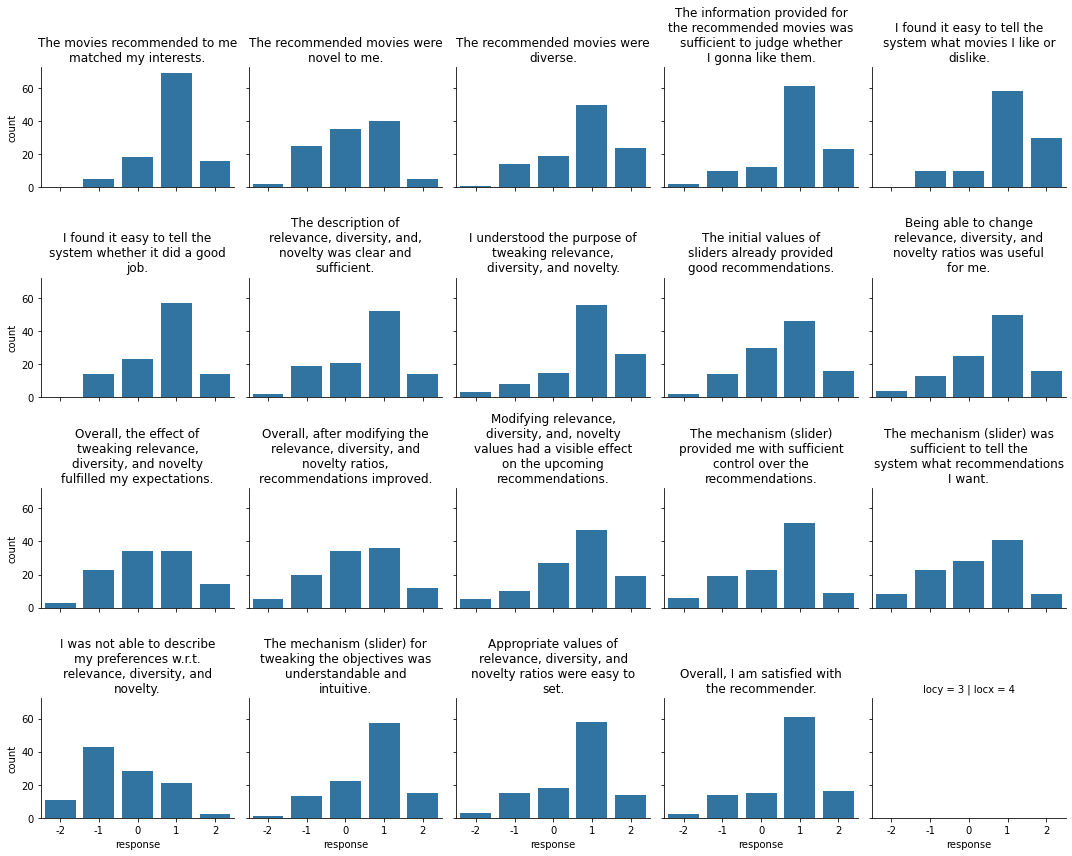

In [23]:
g = sns.FacetGrid(questionsToDisplay, row="locy", col="locx")
g.map(sns.countplot, "response", order=["-2","-1","0","1","2"])

for idx,ax in enumerate(plt.gcf().get_axes()):
    if idx < len(dfLoc):
        ax.set_title("\n".join(wrap(dfLoc.iloc[idx]["question"],28)))
plt.tight_layout()

# How about memory checks

In [24]:
questionsToDisplay2 = questionnaire.loc[questionnaire.correctAnswer != ""]

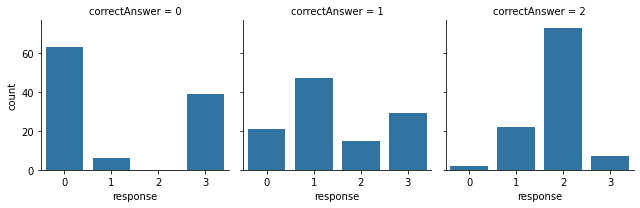

In [25]:
g = sns.FacetGrid(questionsToDisplay2, col="correctAnswer")
g.map(sns.countplot, "response", order=["0","1","2","3"])

In [26]:
tmp = (questionnaire[questionnaire.correctAnswer != ""]).copy().reset_index()
tmp["response"] = tmp["response"].astype("str")
tmp["correctAnswer"] = tmp["correctAnswer"].astype("str")
tmp["correctResponse"] = False
tmp.loc[tmp.response == tmp.correctAnswer,"correctResponse"] = True
tmp

participation query response correctAnswer  correctResponse
0               61   0ch        3             0            False
1               63   0ch        1             2            False
2               64   0ch        1             1             True
3               60   0ch        3             0            False
4               62   0ch        2             2             True
..             ...   ...      ...           ...              ...
319            181   2ch        0             0             True
320            182   2ch        2             1            False
321            177   2ch        0             0             True
322            184   2ch        0             0             True
323            185   2ch        2             1            False

[324 rows x 5 columns]

<AxesSubplot:xlabel='correctResponse', ylabel='count'>

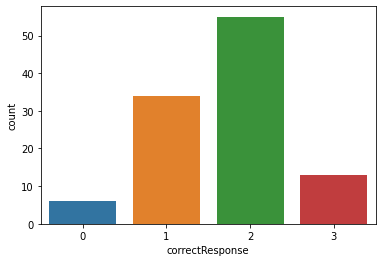

In [27]:
sns.countplot(tmp.groupby("participation")[["correctResponse"]].sum(),x="correctResponse")

In [28]:
tmp.groupby("participation")["correctResponse"].sum().value_counts()

2    55
1    34
3    13
0     6
Name: correctResponse, dtype: int64

# Depict histograms separately for users with high / low attention

In [29]:
participantStats = tmp.groupby("participation")[["correctResponse"]].sum()
participantStats["highAttention"] = participantStats["correctResponse"] >=2

In [30]:
participantStats.to_csv("participant_attention_stats.csv")

In [31]:
questionsToDisplay = questionnaire.loc[questionnaire.correctAnswer == ""]
questionsToDisplay = questionsToDisplay.loc[~questionsToDisplay["query"].str.contains("qs")]
questionsToDisplay = questionsToDisplay.join(dfLoc, on="query")
questionsToDisplay = questionsToDisplay.join(participantStats)

In [32]:
questionsToDisplay

query response correctAnswer  locx  locy  \
participation                                            
60               q1        1                   0     0   
60               q2        1                   1     0   
60               q3        2                   2     0   
60               q4        1                   3     0   
60               q6        2                   4     0   
...             ...      ...           ...   ...   ...   
185             q18        1                   4     2   
185             q20       -1                   0     3   
185             q21        1                   1     3   
185             q23        1                   2     3   
185             q24        1                   3     3   

                                                        question  \
participation                                                      
60             The movies recommended to me matched my intere...   
60                      The recommended movies were novel to me.   
60                          The recommended movies were diverse.   
60             The information provided for the recommended m...   
60             I found it easy to tell the system what movies...   
...                                                          ...   
185            The mechanism (slider) was sufficient to tell ...   
185            I was not able to describe my preferences w.r....   
185            The mechanism (slider) for tweaking the object...   
185            Appropriate values of relevance, diversity, an...   
185                Overall, I am satisfied with the recommender.   

               correctResponse  highAttention  
participation                                  
60                           1          False  
60                           1          False  
60                           1          False  
60                           1          False  
60                           1          False  
...                        ...            ...  
185                          0          False  
185                          0          False  
185                          0          False  
185                          0          False  
185                          0          False  

[2052 rows x 8 columns]

In [33]:
qGroup = questionsToDisplay.groupby(["query","question","response","highAttention","locx","locy"])[["correctResponse"]].count()
qGroup.columns=["countVals"]
qGroup = qGroup.reset_index()
qGroup

query                                           question response  \
0      q1  The movies recommended to me matched my intere...       -1   
1      q1  The movies recommended to me matched my intere...       -1   
2      q1  The movies recommended to me matched my intere...        0   
3      q1  The movies recommended to me matched my intere...        0   
4      q1  The movies recommended to me matched my intere...        1   
..    ...                                                ...      ...   
174    q9  I understood the purpose of tweaking relevance...        0   
175    q9  I understood the purpose of tweaking relevance...        1   
176    q9  I understood the purpose of tweaking relevance...        1   
177    q9  I understood the purpose of tweaking relevance...        2   
178    q9  I understood the purpose of tweaking relevance...        2   

     highAttention  locx  locy  countVals  
0            False     0     0          2  
1             True     0     0          3  
2            False     0     0          9  
3             True     0     0          9  
4            False     0     0         23  
..             ...   ...   ...        ...  
174           True     2     1         11  
175          False     2     1         24  
176           True     2     1         32  
177          False     2     1          9  
178           True     2     1         17  

[179 rows x 7 columns]

In [34]:
qDivisor = qGroup.groupby(["highAttention"])["countVals"].sum() / len(qGroup["query"].unique())
qGroup = qGroup.set_index(["query","highAttention"])
qGroup["countVals"] = qGroup["countVals"] / qDivisor
qGroup = qGroup.reset_index()
qGroup

query  highAttention                                           question  \
0      q1          False  The movies recommended to me matched my intere...   
1      q1           True  The movies recommended to me matched my intere...   
2      q1          False  The movies recommended to me matched my intere...   
3      q1           True  The movies recommended to me matched my intere...   
4      q1          False  The movies recommended to me matched my intere...   
..    ...            ...                                                ...   
174    q9           True  I understood the purpose of tweaking relevance...   
175    q9          False  I understood the purpose of tweaking relevance...   
176    q9           True  I understood the purpose of tweaking relevance...   
177    q9          False  I understood the purpose of tweaking relevance...   
178    q9           True  I understood the purpose of tweaking relevance...   

    response  locx  locy  countVals  
0         -1     0     0   0.050000  
1         -1     0     0   0.044118  
2          0     0     0   0.225000  
3          0     0     0   0.132353  
4          1     0     0   0.575000  
..       ...   ...   ...        ...  
174        0     2     1   0.161765  
175        1     2     1   0.600000  
176        1     2     1   0.470588  
177        2     2     1   0.225000  
178        2     2     1   0.250000  

[179 rows x 7 columns]

Results:
- cannot really see much difference, unfortunatelly


{'False': <BarContainer object of 5 artists>, 'True': <BarContainer object of 5 artists>}


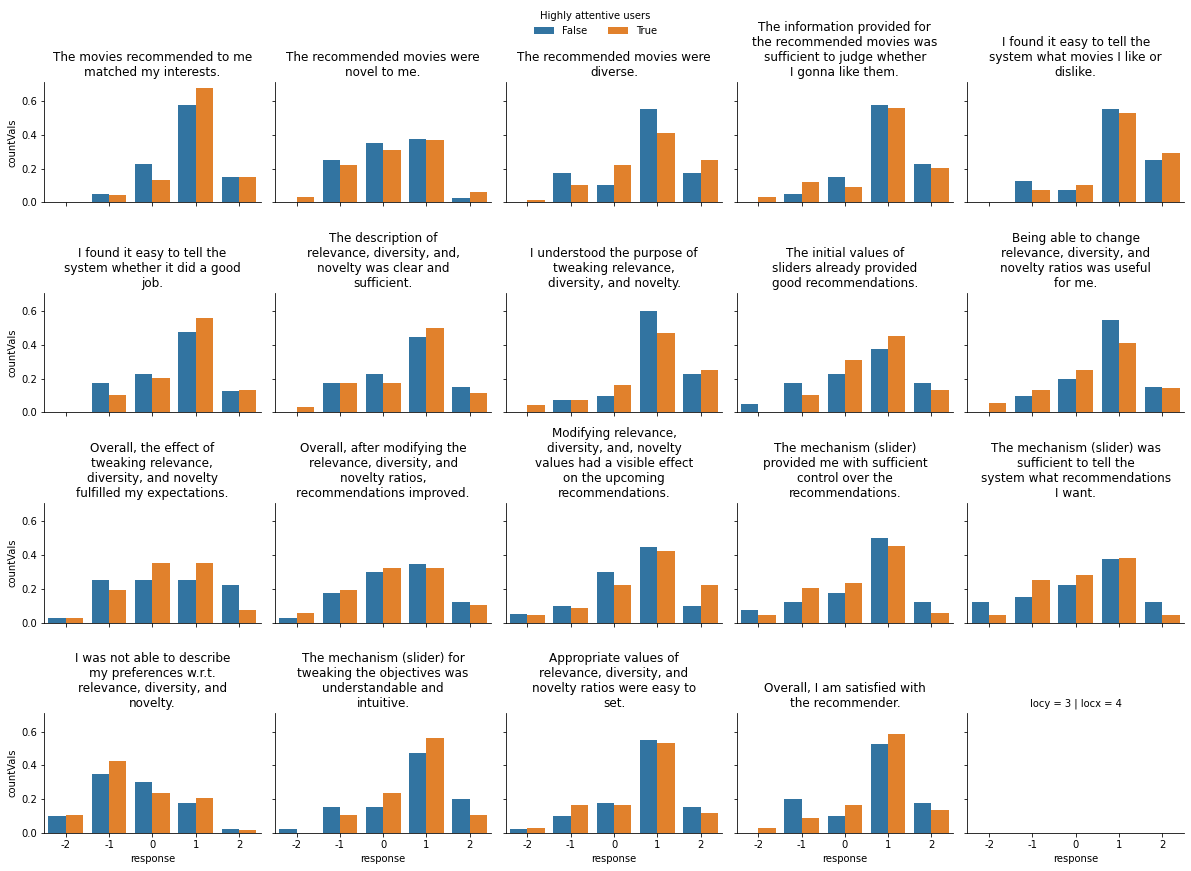

In [35]:
sns.set_palette("flare")
def barplot(x, y, hue, **kwargs):
    sns.barplot(x=x, y=y, hue=hue, **kwargs)

g = sns.FacetGrid(qGroup, row="locy", col="locx")
g.map(barplot, "response", "countVals", "highAttention", order=["-2","-1","0","1","2"], palette="tab10")

for idx,ax in enumerate(plt.gcf().get_axes()):
    if idx < len(dfLoc):
        ax.set_title("\n".join(wrap(dfLoc.iloc[idx]["question"],28)))
g.add_legend(g._legend_data, title="Highly attentive users")
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, 0.96), ncol=3, frameon=False,)
print(g._legend_data)
plt.tight_layout()

In [295]:
from scipy.stats import median_test,ttest_ind
highAttentionTrue = questionsToDisplay.loc[((questionsToDisplay["query"]=="q12")&(questionsToDisplay["highAttention"]==True)),"response"].astype(int)
highAttentionFalse = questionsToDisplay.loc[((questionsToDisplay["query"]=="q12")&(questionsToDisplay["highAttention"]==False)),"response"].astype(int)

median_test(highAttentionTrue, highAttentionFalse)



MedianTestResult(statistic=0.0, pvalue=1.0, median=1.0, table=array([[10,  6],
       [58, 34]], dtype=int64))

In [296]:
highAttentionTrue.mean(),highAttentionFalse.mean()

(0.45588235294117646, 0.75)

In [297]:
ttest_ind(highAttentionTrue, highAttentionFalse, alternative="greater")

Ttest_indResult(statistic=-1.4734717495694194, pvalue=0.9282063288279274)

# Results w.r.t. the relative preference of users towards MORS vs. SORS 

In [210]:
morsPreference = pd.read_csv("morsVSsingleObjSelections.csv")
preferingMORS = morsPreference.loc[morsPreference.numSelected > 0.37,"userId"].values
preferingSORS = morsPreference.loc[morsPreference.numSelected <= 0.37,"userId"].values

questionsToDisplay["preferingMORS"] = False
questionsToDisplay.loc[questionsToDisplay.index.isin(preferingMORS),"preferingMORS"]=True 
questionsToDisplay

query response correctAnswer  locx  locy  \
participation                                            
60               q1        1                   0     0   
60               q2        1                   1     0   
60               q3        2                   2     0   
60               q4        1                   3     0   
60               q6        2                   4     0   
...             ...      ...           ...   ...   ...   
185             q18        1                   4     2   
185             q20       -1                   0     3   
185             q21        1                   1     3   
185             q23        1                   2     3   
185             q24        1                   3     3   

                                                        question  \
participation                                                      
60             The movies recommended to me matched my intere...   
60                      The recommended movies were novel to me.   
60                          The recommended movies were diverse.   
60             The information provided for the recommended m...   
60             I found it easy to tell the system what movies...   
...                                                          ...   
185            The mechanism (slider) was sufficient to tell ...   
185            I was not able to describe my preferences w.r....   
185            The mechanism (slider) for tweaking the object...   
185            Appropriate values of relevance, diversity, an...   
185                Overall, I am satisfied with the recommender.   

               correctResponse  highAttention  preferingMORS  highSelect  
participation                                                             
60                           1          False           True        True  
60                           1          False           True        True  
60                           1          False           True        True  
60                           1          False           True        True  
60                           1          False           True        True  
...                        ...            ...            ...         ...  
185                          0          False           True       False  
185                          0          False           True       False  
185                          0          False           True       False  
185                          0          False           True       False  
185                          0          False           True       False  

[2052 rows x 10 columns]

In [211]:
morsPreference.loc[morsPreference.numSelected > 0.37,"userId"].values.shape

(51,)

In [212]:
qGroup = questionsToDisplay.groupby(["query","question","response","preferingMORS","locx","locy"])[["correctResponse"]].count()
qGroup.columns=["countVals"]
qGroup = qGroup.reset_index()

qDivisor = qGroup.groupby(["preferingMORS"])["countVals"].sum() / len(qGroup["query"].unique())
qGroup = qGroup.set_index(["query","preferingMORS"])
qGroup["countVals"] = qGroup["countVals"] / qDivisor
qGroup = qGroup.reset_index()
qGroup

query  preferingMORS                                           question  \
0      q1          False  The movies recommended to me matched my intere...   
1      q1           True  The movies recommended to me matched my intere...   
2      q1          False  The movies recommended to me matched my intere...   
3      q1           True  The movies recommended to me matched my intere...   
4      q1          False  The movies recommended to me matched my intere...   
..    ...            ...                                                ...   
175    q9           True  I understood the purpose of tweaking relevance...   
176    q9          False  I understood the purpose of tweaking relevance...   
177    q9           True  I understood the purpose of tweaking relevance...   
178    q9          False  I understood the purpose of tweaking relevance...   
179    q9           True  I understood the purpose of tweaking relevance...   

    response  locx  locy  countVals  
0         -1     0     0   0.052632  
1         -1     0     0   0.039216  
2          0     0     0   0.122807  
3          0     0     0   0.215686  
4          1     0     0   0.719298  
..       ...   ...   ...        ...  
175        0     2     1   0.156863  
176        1     2     1   0.421053  
177        1     2     1   0.627451  
178        2     2     1   0.333333  
179        2     2     1   0.137255  

[180 rows x 7 columns]

{'False': <BarContainer object of 5 artists>, 'True': <BarContainer object of 5 artists>}


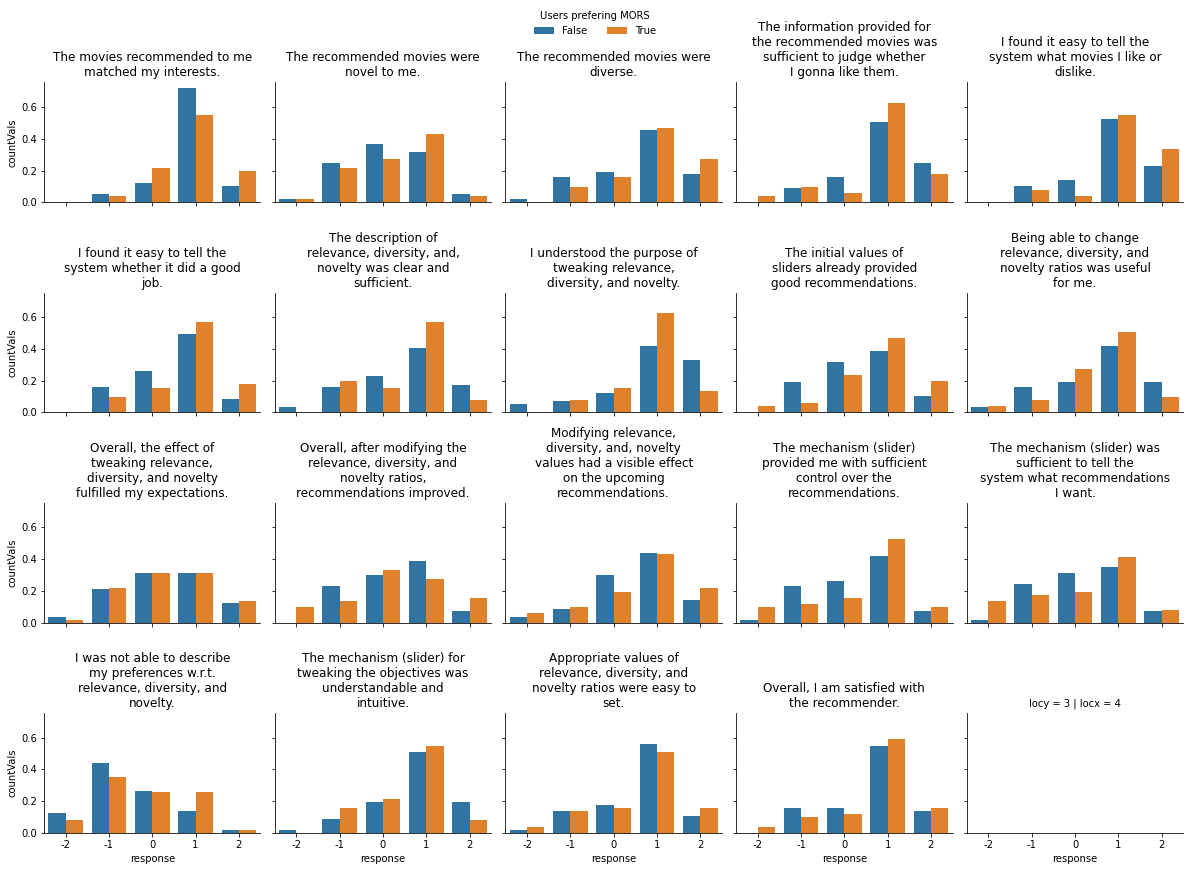

In [213]:
sns.set_palette("flare")
def barplot(x, y, hue, **kwargs):
    sns.barplot(x=x, y=y, hue=hue, **kwargs)

g = sns.FacetGrid(qGroup, row="locy", col="locx")
g.map(barplot, "response", "countVals", "preferingMORS", order=["-2","-1","0","1","2"], palette="tab10")

for idx,ax in enumerate(plt.gcf().get_axes()):
    if idx < len(dfLoc):
        ax.set_title("\n".join(wrap(dfLoc.iloc[idx]["question"],28)))
g.add_legend(g._legend_data, title="Users prefering MORS")
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, 0.96), ncol=3, frameon=False,)
print(g._legend_data)
plt.tight_layout()

In [298]:
from scipy.stats import median_test,ttest_ind
morsTrue = questionsToDisplay.loc[((questionsToDisplay["query"]=="q11")&(questionsToDisplay["preferingMORS"]==True)),"response"].astype(int)
morsFalse = questionsToDisplay.loc[((questionsToDisplay["query"]=="q11")&(questionsToDisplay["preferingMORS"]==False)),"response"].astype(int)

median_test(morsTrue, morsFalse)



MedianTestResult(statistic=1.11303674787993, pvalue=0.2914227783587155, median=1.0, table=array([[10,  6],
       [41, 51]], dtype=int64))

In [299]:
morsTrue.mean(),morsFalse.mean()

(0.7254901960784313, 0.40350877192982454)

In [300]:
ttest_ind(morsTrue, morsFalse, alternative="greater")

Ttest_indResult(statistic=1.75646325870931, pvalue=0.0409486415301903)

Significant results:
- q7 (tell whether it did a good job)
- q11 (initial values were already good)
- q20 (MORS users were more often unable to describe preferences w.r.t. nov, div and rel)

# Results w.r.t. overall volume of selections

In [127]:
totalSelections = pd.read_csv("totalSelections.csv")
highSelect = totalSelections.loc[totalSelections.numSelected > 50,"userId"].values
lowSelect = totalSelections.loc[totalSelections.numSelected <= 50,"userId"].values

questionsToDisplay["highSelect"] = False
questionsToDisplay.loc[questionsToDisplay.index.isin(highSelect),"highSelect"]=True 
questionsToDisplay

query response correctAnswer  locx  locy  \
participation                                            
60               q1        1                   0     0   
60               q2        1                   1     0   
60               q3        2                   2     0   
60               q4        1                   3     0   
60               q6        2                   4     0   
...             ...      ...           ...   ...   ...   
185             q18        1                   4     2   
185             q20       -1                   0     3   
185             q21        1                   1     3   
185             q23        1                   2     3   
185             q24        1                   3     3   

                                                        question  \
participation                                                      
60             The movies recommended to me matched my intere...   
60                      The recommended movies were novel to me.   
60                          The recommended movies were diverse.   
60             The information provided for the recommended m...   
60             I found it easy to tell the system what movies...   
...                                                          ...   
185            The mechanism (slider) was sufficient to tell ...   
185            I was not able to describe my preferences w.r....   
185            The mechanism (slider) for tweaking the object...   
185            Appropriate values of relevance, diversity, an...   
185                Overall, I am satisfied with the recommender.   

               correctResponse  highAttention  preferingMORS  highSelect  
participation                                                             
60                           1          False           True        True  
60                           1          False           True        True  
60                           1          False           True        True  
60                           1          False           True        True  
60                           1          False           True        True  
...                        ...            ...            ...         ...  
185                          0          False           True       False  
185                          0          False           True       False  
185                          0          False           True       False  
185                          0          False           True       False  
185                          0          False           True       False  

[2052 rows x 10 columns]

In [129]:
totalSelections.loc[totalSelections.numSelected > 45,"userId"].values.shape

(58,)

In [130]:
qGroup = questionsToDisplay.groupby(["query","question","response","highSelect","locx","locy"])[["correctResponse"]].count()
qGroup.columns=["countVals"]
qGroup = qGroup.reset_index()

qDivisor = qGroup.groupby(["highSelect"])["countVals"].sum() / len(qGroup["query"].unique())
qGroup = qGroup.set_index(["query","highSelect"])
qGroup["countVals"] = qGroup["countVals"] / qDivisor
qGroup = qGroup.reset_index()
qGroup

query  highSelect                                           question  \
0      q1       False  The movies recommended to me matched my intere...   
1      q1       False  The movies recommended to me matched my intere...   
2      q1        True  The movies recommended to me matched my intere...   
3      q1       False  The movies recommended to me matched my intere...   
4      q1        True  The movies recommended to me matched my intere...   
..    ...         ...                                                ...   
174    q9        True  I understood the purpose of tweaking relevance...   
175    q9       False  I understood the purpose of tweaking relevance...   
176    q9        True  I understood the purpose of tweaking relevance...   
177    q9       False  I understood the purpose of tweaking relevance...   
178    q9        True  I understood the purpose of tweaking relevance...   

    response  locx  locy  countVals  
0         -1     0     0   0.078125  
1          0     0     0   0.203125  
2          0     0     0   0.113636  
3          1     0     0   0.640625  
4          1     0     0   0.636364  
..       ...   ...   ...        ...  
174        0     2     1   0.136364  
175        1     2     1   0.500000  
176        1     2     1   0.545455  
177        2     2     1   0.265625  
178        2     2     1   0.204545  

[179 rows x 7 columns]

{'False': <BarContainer object of 5 artists>, 'True': <BarContainer object of 5 artists>}


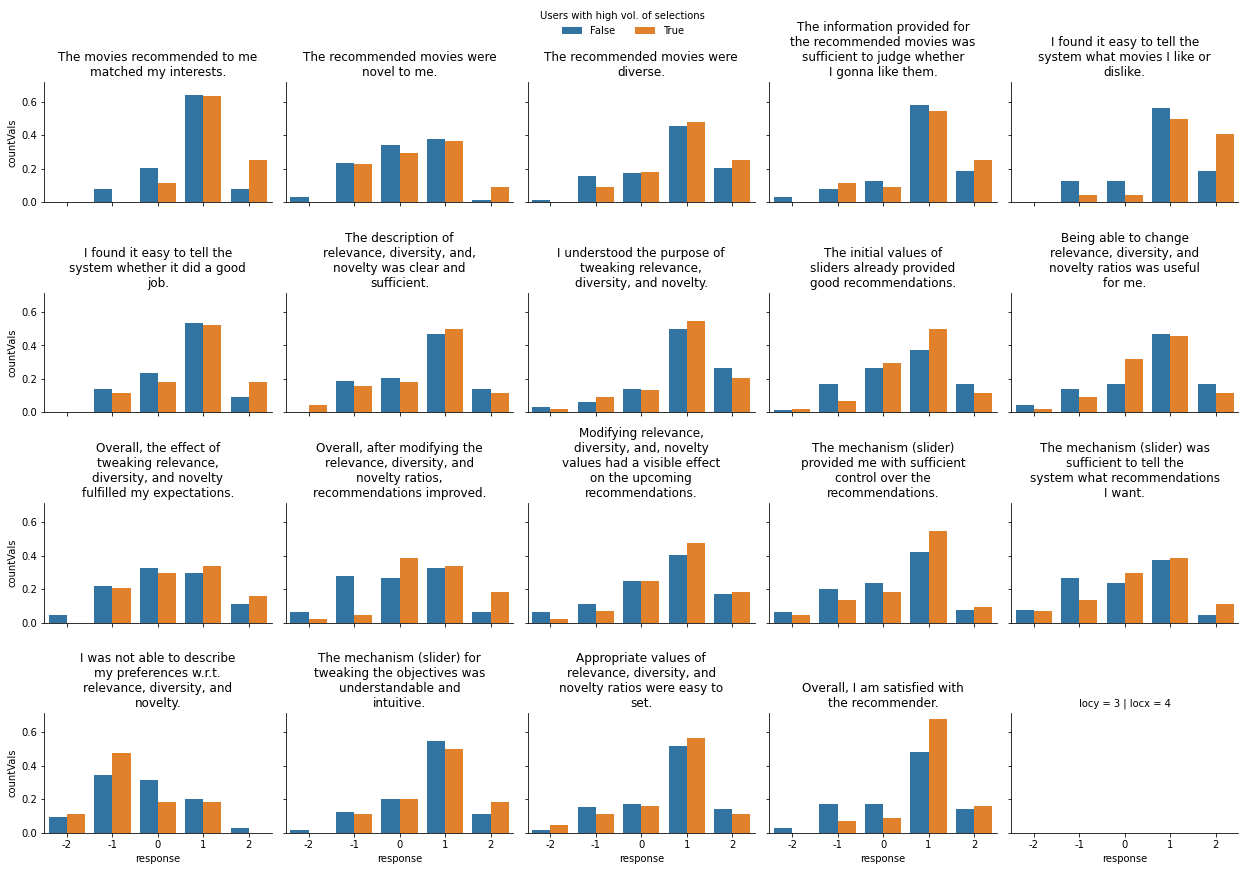

In [132]:
sns.set_palette("flare")
def barplot(x, y, hue, **kwargs):
    sns.barplot(x=x, y=y, hue=hue, **kwargs)

g = sns.FacetGrid(qGroup, row="locy", col="locx")
g.map(barplot, "response", "countVals", "highSelect", order=["-2","-1","0","1","2"], palette="tab10")

for idx,ax in enumerate(plt.gcf().get_axes()):
    if idx < len(dfLoc):
        ax.set_title("\n".join(wrap(dfLoc.iloc[idx]["question"],28)))
g.add_legend(g._legend_data, title="Users with high vol. of selections")
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, 0.96), ncol=3, frameon=False,)
print(g._legend_data)
plt.tight_layout()

In [204]:
from scipy.stats import median_test,ttest_ind
highSelect = questionsToDisplay.loc[((questionsToDisplay["query"]=="q17")&(questionsToDisplay["highSelect"]==True)),"response"].astype(int)
lowSelect = questionsToDisplay.loc[((questionsToDisplay["query"]=="q17")&(questionsToDisplay["highSelect"]==False)),"response"].astype(int)

median_test(highSelect, lowSelect)


MedianTestResult(statistic=0.0, pvalue=1.0, median=1.0, table=array([[ 4,  5],
       [40, 59]], dtype=int64))

In [205]:
highSelect.mean(),lowSelect.mean()

(0.5, 0.25)

In [206]:
ttest_ind(highSelect, lowSelect, alternative="greater")

Ttest_indResult(statistic=1.225599199471659, pvalue=0.11153282430644752)

significant results on
- q1 (perceived relevance, unsurprisingly)
- q15 (perceived improvement after slider modifications)
- q24 (overall satisfaction - not surprising)

### Results:
- users who prefered the 

In [48]:
avg_answers_old = df_interaction[df_interaction.columns[5:]].astype(int)
avg_answers_old = avg_answers_old.mean().reset_index()
avg_answers_old = avg_answers_old.rename(columns={0: "avg_value", "index": "question"})
avg_answers_old.loc[:, "idx"] = avg_answers_old.index
avg_answers_old.loc[:, "most_freq"] = avg_answers_old.question.map(lambda x: [a_to_text[y] for y in df_interaction[x].mode().values])
avg_answers_old.loc[:, "avg"] = avg_answers_old.avg_value.map(lambda x: a_txt_values[(np.abs(a_values - x)).argmin()]) 
avg_answers_old.question = avg_answers_old.question.map(lambda x: q_to_text[x] if x in q_to_text else x)
avg_answers_old

KeyError: 2

## Analyze new data

In [ ]:
df_interaction = pd.read_json("data/14-4-2023 18-58/interaction-export.json", encoding='utf-8')
df_participation = pd.read_json("data/14-4-2023 18-58/participation-export.json", encoding="utf-8")
df_participation.loc[:, "prolific_pid"] = df_participation.extra_data.map(get_prolific_pid)
df_participation = df_participation[df_participation.user_study_id >= 3]
df_participation = df_participation.set_index("id")
df_participation = df_participation[df_participation.participant_email != "a@a.a"]
df_participation = df_participation[df_participation.time_finished.notna()]
df_interaction = df_interaction[df_interaction.participation.isin(df_participation.index)]
df_interaction_full = df_interaction.copy()
df_interaction = df_interaction[df_interaction.interaction_type == "final-questionnaire"]

In [ ]:
df_interaction = df_interaction.apply(columnify_answers, axis=1)

In [ ]:
# avg_answers = df_interaction[df_interaction.columns[5:]].astype(int)
# Because it was joinned
avg_answers_new = df_interaction[df_interaction.columns[16:]].astype(int)
avg_answers_new = avg_answers_new.mean().reset_index()
avg_answers_new = avg_answers_new.rename(columns={0: "avg_value", "index": "question"})
avg_answers_new.loc[:, "idx"] = avg_answers_new.index
avg_answers_new.loc[:, "most_freq"] = avg_answers_new.question.map(lambda x: [a_to_text[y] for y in df_interaction[x].mode().values])
avg_answers_new.loc[:, "avg"] = avg_answers_new.avg_value.map(lambda x: a_txt_values[(np.abs(a_values - x)).argmin()]) 
avg_answers_new.question = avg_answers_new.question.map(lambda x: q_to_text[x] if x in q_to_text else x)
avg_answers_new

In [ ]:
avg_answers_merged = avg_answers_old.copy()
avg_answers_merged.loc[:, "new_avg_value"] = avg_answers_new["avg_value"]
avg_answers_merged.loc[:, "new_most_freq"] = avg_answers_new["most_freq"]
avg_answers_merged.loc[:, "new_avg"] = avg_answers_new["avg"]
avg_answers_merged